In [1]:
import tqdm
import pandas as pd 
import numpy as np 
import os
from itertools import chain
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU') 
        print(gpus[0].name)
    except RuntimeError as e:
        print(e)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
img_labels_df = pd.read_csv('data/image_labels.csv')

img_labels_df

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,original_y_spacing
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [7]:
img_labels_df['split_diagnoses'] = img_labels_df.apply(lambda x: x['diagnosis'].split('|'), axis=1)
img_labels_df = img_labels_df[img_labels_df['split_diagnoses'].apply(lambda x: len(x) == 1)]
no_finding_df = img_labels_df[img_labels_df['diagnosis'] == 'No Finding']
no_finding_df.shape
no_findings_rows_to_drop = no_finding_df.sample(frac=1).index
img_labels_df = img_labels_df.drop(no_findings_rows_to_drop)

In [8]:
class_counts = img_labels_df['diagnosis'].value_counts()
classes_to_drop = class_counts[class_counts < 1000].index.tolist()
img_labels_df = img_labels_df[~img_labels_df['diagnosis'].isin(classes_to_drop)]

In [9]:
all_diagnoses = list(set(chain(*img_labels_df['diagnosis'].map(lambda x: x.split('|')).tolist())))
for diagnosis in all_diagnoses:
    img_labels_df[diagnosis] = img_labels_df['diagnosis'].map(lambda diagnoses: diagnosis in diagnoses)

diagnosis_counts = {diagnosis: img_labels_df[diagnosis].sum() for diagnosis in all_diagnoses}

print(f"Dataframe Shape: {img_labels_df.shape}")
img_labels_df.head(10)

Dataframe Shape: (28284, 21)


,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,split_diagnoses,Cardiomegaly,Atelectasis,Nodule,Effusion,Mass,Pneumothorax,Consolidation,Infiltration,Pleural_Thickening
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,[Cardiomegaly],True,False,False,False,False,False,False,False,False
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,[Infiltration],False,False,False,False,False,False,False,True,False
23,00000008_000.png,Cardiomegaly,0,8,68,F,PA,2048,2500,0.171,...,[Cardiomegaly],True,False,False,False,False,False,False,False,False
25,00000008_002.png,Nodule,2,8,72,F,PA,2048,2500,0.168,...,[Nodule],False,False,True,False,False,False,False,False,False
27,00000010_000.png,Infiltration,0,10,84,F,PA,2992,2991,0.143,...,[Infiltration],False,False,False,False,False,False,False,True,False
28,00000011_000.png,Effusion,0,11,74,M,PA,2638,2449,0.143,...,[Effusion],False,False,False,True,False,False,False,False,False
33,00000011_005.png,Infiltration,5,11,75,M,AP,2500,2048,0.168,...,[Infiltration],False,False,False,False,False,False,False,True,False
34,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143,...,[Atelectasis],False,True,False,False,False,False,False,False,False
35,00000011_007.png,Infiltration,7,11,75,M,PA,2782,2753,0.143,...,[Infiltration],False,False,False,False,False,False,False,True,False
40,00000013_024.png,Mass,2,13,56,M,AP,2500,2048,0.168,...,[Mass],False,False,False,False,True,False,False,False,False


In [10]:
img_labels_df['vectorized_diagnoses'] = img_labels_df.apply(lambda x: [x[all_diagnoses].values], 1).map(lambda x: [float(val) for val in x[0]])
img_labels_df["img_path"] = img_labels_df['img_name'].apply(lambda x: "./data/images/" + x)

In [11]:
split: list[pd.DataFrame] = train_test_split(img_labels_df, test_size=0.15, random_state=2003)
training_df, validation_df = split
print(f"Training Size: {len(training_df)}\nValidation Size: {len(validation_df)}")

Training Size: 24041
Validation Size: 4243


In [12]:
training_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Atelectasis,Nodule,Effusion,Mass,Pneumothorax,Consolidation,Infiltration,Pleural_Thickening,vectorized_diagnoses,img_path
2695,00000711_000.png,Mass,8,711,43,F,PA,2992,2991,0.143000,...,False,False,False,True,False,False,False,False,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00000711_000.png
33566,00008803_005.png,Infiltration,5,8803,16,F,AP,2048,2500,0.168000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00008803_005.png
43648,00011237_113.png,Infiltration,112,11237,56,F,AP,2500,2048,0.168000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00011237_113.png
66311,00016404_011.png,Nodule,11,16404,44,M,AP,2500,2048,0.168000,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00016404_011.png
111718,00030608_000.png,Cardiomegaly,0,30608,40,F,PA,3056,2544,0.139000,...,False,False,False,False,False,False,False,False,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00030608_000.png
1292,00000324_015.png,Atelectasis,15,324,36,M,AP,2500,2048,0.168000,...,True,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00000324_015.png
107339,00028974_016.png,Effusion,16,28974,76,M,AP,3056,2544,0.139000,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00028974_016.png
108511,00029433_001.png,Infiltration,1,29433,58,F,AP,3056,2544,0.139000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00029433_001.png
874,00000211_028.png,Effusion,28,211,59,F,PA,2474,2513,0.143000,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00000211_028.png
5959,00001606_002.png,Atelectasis,6,1606,51,F,PA,2020,2021,0.194311,...,True,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00001606_002.png


In [13]:
validation_df.sample(10)

,img_name,diagnosis,follow_up_num,patient_id,patient_age,patient_gender,view_position,original_width,original_height,original_x_spacing,...,Atelectasis,Nodule,Effusion,Mass,Pneumothorax,Consolidation,Infiltration,Pleural_Thickening,vectorized_diagnoses,img_path
76627,00018836_002.png,Nodule,2,18836,49,M,PA,2500,2048,0.168000,...,False,True,False,False,False,False,False,False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00018836_002.png
57178,00014197_004.png,Infiltration,28,14197,58,M,AP,3056,2544,0.139000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00014197_004.png
7692,00002015_005.png,Pleural_Thickening,3,2015,60,F,AP,2704,2544,0.139000,...,False,False,False,False,False,False,False,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",./data/images/00002015_005.png
72317,00017818_001.png,Infiltration,1,17818,28,M,AP,2500,2048,0.168000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00017818_001.png
34713,00009144_000.png,Effusion,0,9144,32,M,AP,2500,2048,0.168000,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00009144_000.png
13295,00003459_013.png,Infiltration,13,3459,52,F,AP,2500,2048,0.171000,...,False,False,False,False,False,False,True,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",./data/images/00003459_013.png
7555,00001984_004.png,Pneumothorax,15,1984,66,M,PA,2992,2991,0.143000,...,False,False,False,False,True,False,False,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",./data/images/00001984_004.png
109693,00029839_008.png,Effusion,8,29839,36,M,PA,1890,2021,0.194311,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00029839_008.png
35427,00009349_008.png,Atelectasis,7,9349,69,M,AP,2500,2048,0.168000,...,True,False,False,False,False,False,False,False,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00009349_008.png
15444,00004034_016.png,Effusion,15,4034,48,F,PA,2992,2991,0.143000,...,False,False,True,False,False,False,False,False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",./data/images/00004034_016.png


In [14]:
idg_parameterized = ImageDataGenerator(height_shift_range= 0.07,
                                  width_shift_range=0.12,
                                  rotation_range=5,
                                  zoom_range=0.17,
                                  shear_range = 0.12,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  fill_mode = 'reflect',
                                )
img_dimensions = (128, 128)

In [15]:
training_gen = idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = "img_path",
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 32)

Found 24041 validated image filenames belonging to 9 classes.


In [16]:
validation_gen = idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                            directory=None,
                            x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                            class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                            color_mode = 'rgb',
                            batch_size = 256)

Found 4243 validated image filenames belonging to 9 classes.


In [17]:
t_X, t_Y = next(idg_parameterized.flow_from_dataframe(dataframe=training_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 24041 validated image filenames belonging to 9 classes.


In [18]:
v_X, v_Y = next(idg_parameterized.flow_from_dataframe(dataframe=validation_df, 
                             directory=None,
                             x_col = 'img_path',
                            y_col = 'split_diagnoses', 
                             class_mode = 'categorical',
                            classes = all_diagnoses,
                            target_size = img_dimensions,
                             color_mode = 'rgb',
                            batch_size = 1024))

Found 4243 validated image filenames belonging to 9 classes.


In [19]:
print(len(t_X[0]))

128


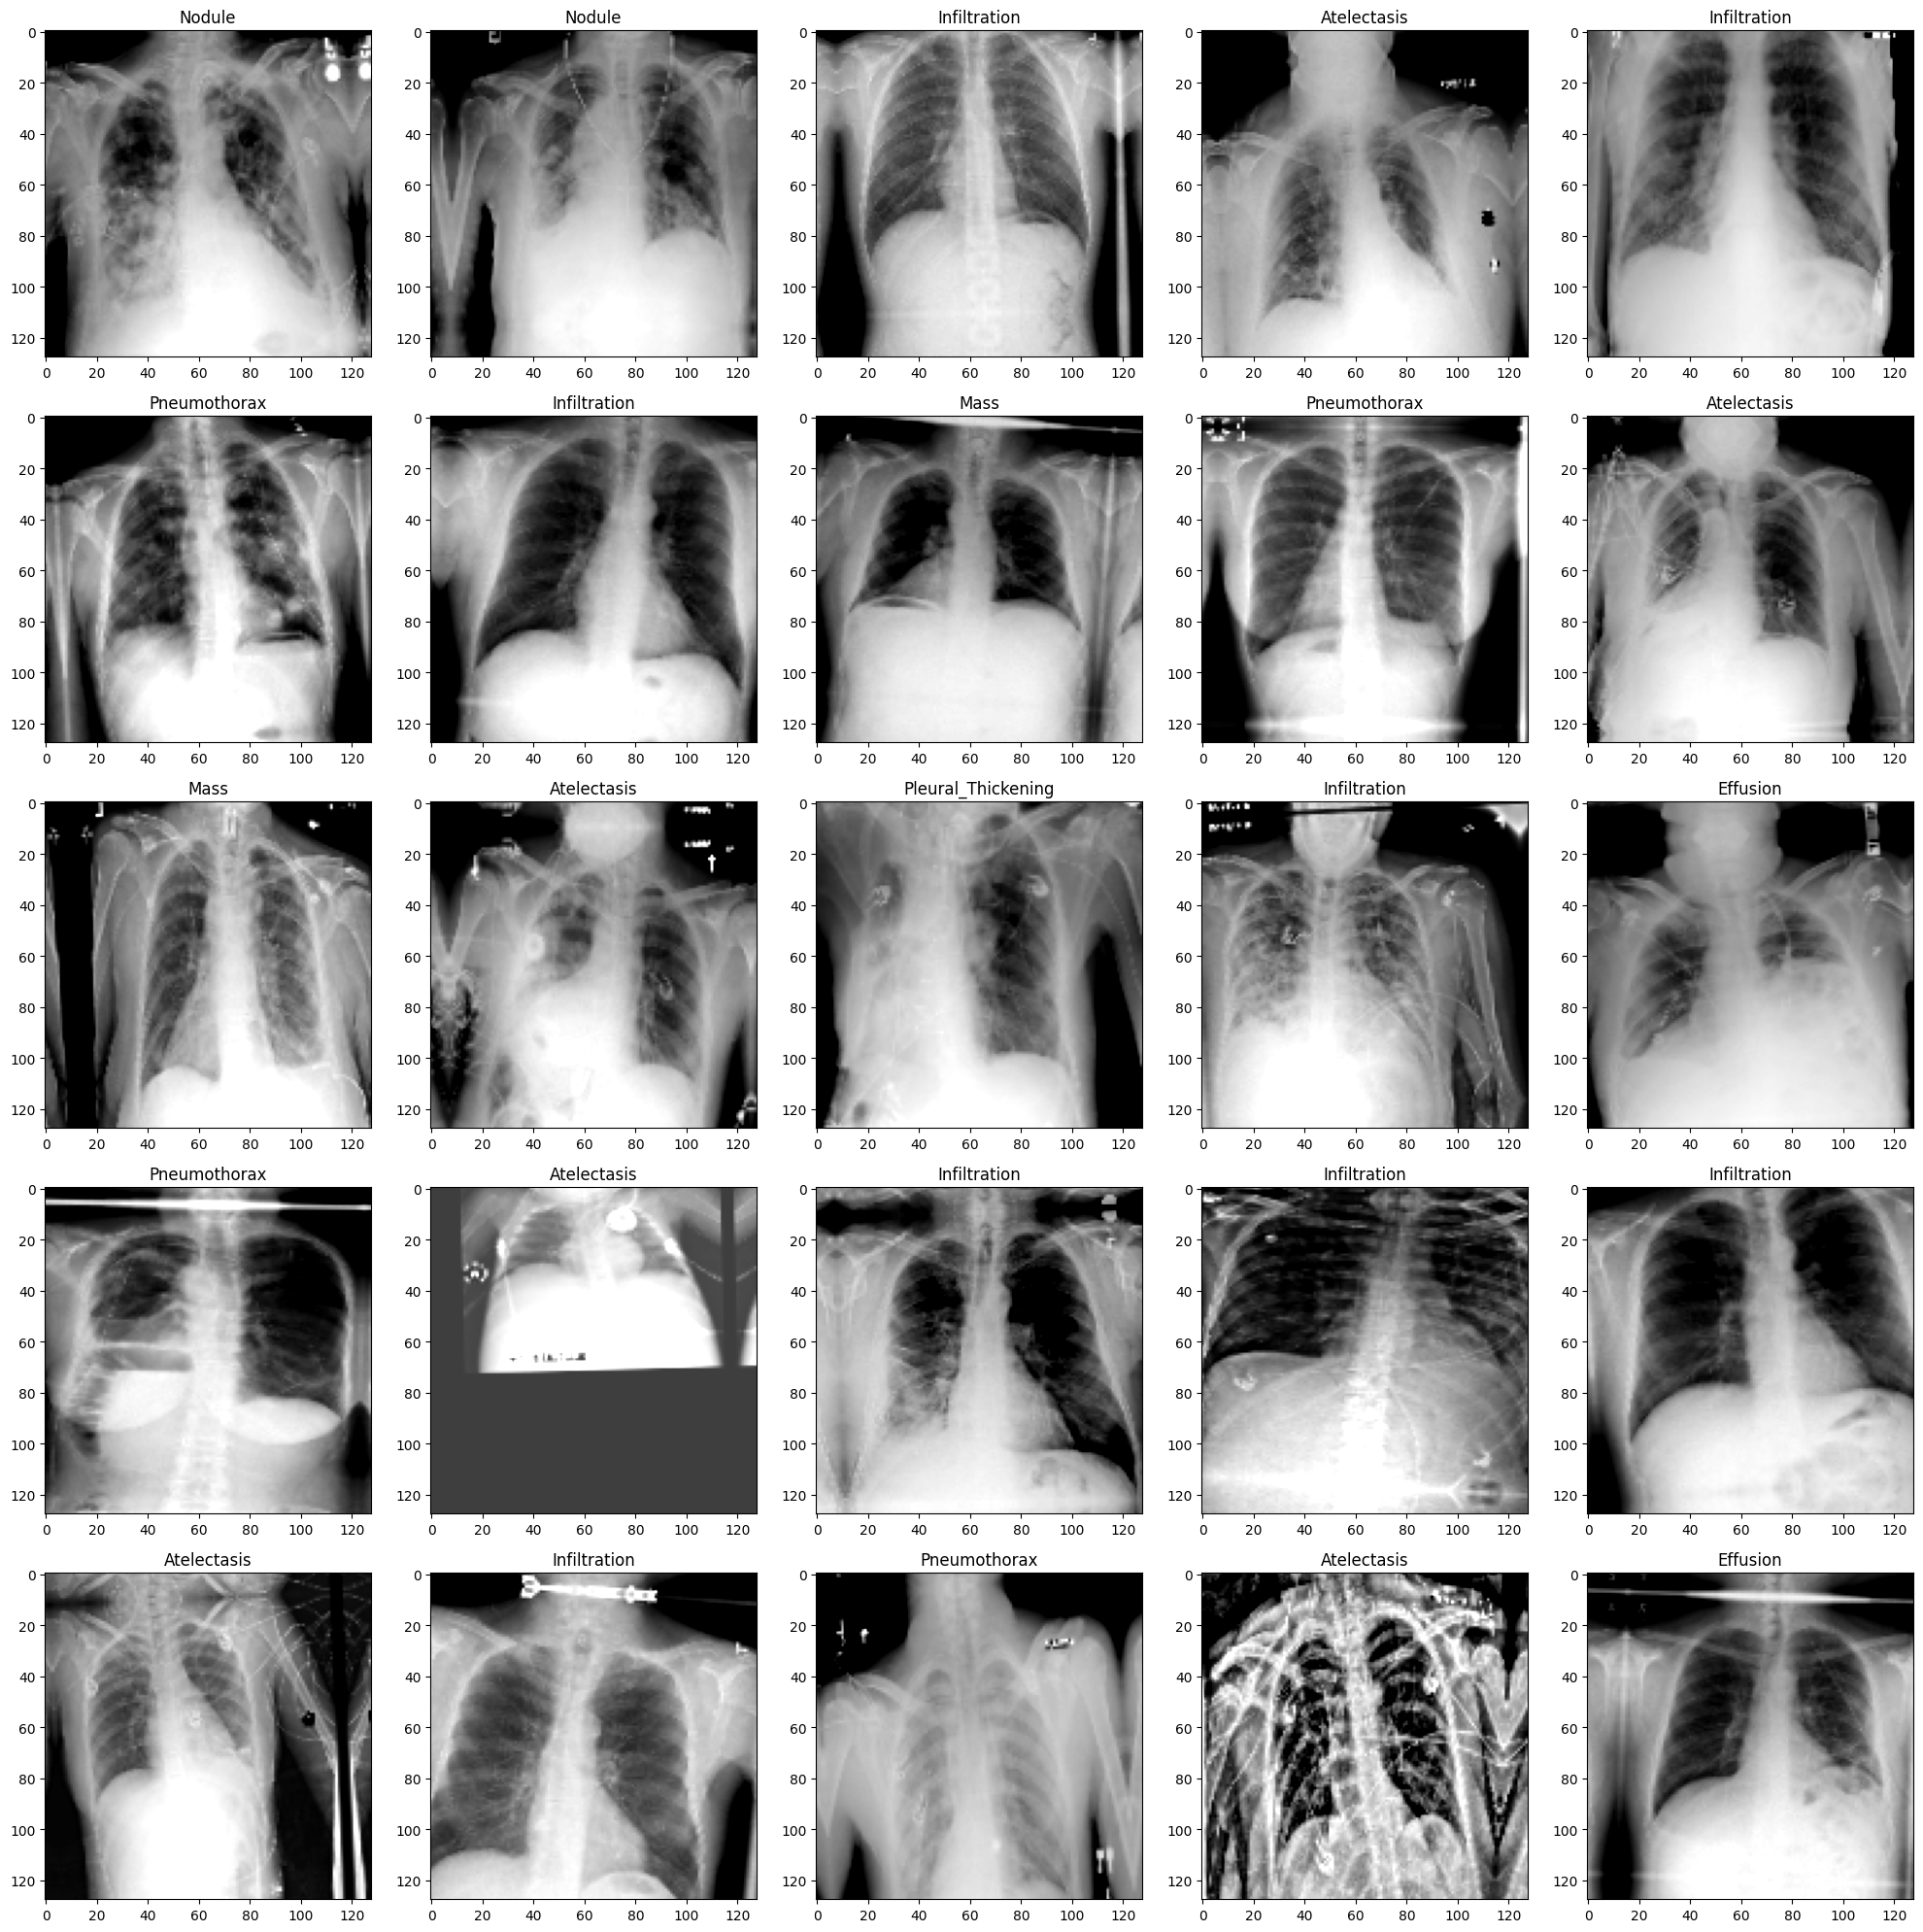

In [20]:
grid_size = 5

tr_x, tr_y = next(training_gen)

fig, matrix_axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
for (img, labels, ax) in zip(tr_x, tr_y, matrix_axs.flatten()):
    ax.imshow(img[:, :, 0], cmap='gist_gray', vmin=-1.5, vmax=1.5)
    title = ', '.join([diagnosis for diagnosis, score in zip(all_diagnoses, labels) if score > 0.5])
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [28]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Multiply, Add

def simple_attention_block(input_tensor):
    # Create an attention feature map with one channel
    attention_features = Conv2D(1, (1, 1), padding='same')(input_tensor)
    attention_features = BatchNormalization()(attention_features)
    attention_weights = Activation('sigmoid')(attention_features)
    
    # Apply the attention weights
    weighted_input = Multiply()([input_tensor, attention_weights])
    output = Add()([weighted_input, input_tensor])
    return output, attention_weights

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

input_tensor = Input(shape=(128, 128, 3))  # RGB input

# VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze VGG layers

x = base_model(input_tensor)

# Simple attention layer
x, attention_weights = simple_attention_block(x)

# Classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(len(all_diagnoses), activation='softmax')(x)  # Output layer for classification

model = Model(inputs=input_tensor, outputs=output_tensor)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Assuming 'training_gen' and 'validation_gen' are already defined
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=1,
    callbacks=callbacks  # Assuming 'callbacks' are already defined
)

In [24]:
# Modify model to output attention weights
visualization_model = Model(inputs=model.input, outputs=[model.output, attention_weights])

# Get predictions and attention weights for a batch of data
predictions, attention_weights_batch = visualization_model.predict(v_X)

# Code to plot the attention weights over images
import matplotlib.pyplot as plt

def plot_attention(image, attention_weights):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    attention_plot = plt.imshow(attention_weights[:, :, 0], cmap='jet', alpha=0.5)
    plt.colorbar(attention_plot)
    plt.title("Attention Weights")

    plt.show()

# Example: Visualize attention for the first image in the batch
plot_attention(v_X[0, :, :, 0], attention_weights_batch[0])

752/752 [==============================] - ETA: 0s - loss: 1.8539 - accuracy: 0.3578
Epoch 1: val_loss improved from inf to 1.79597, saving model to model-best.h5
752/752 [==============================] - 1038s 1s/step - loss: 1.8539 - accuracy: 0.3578 - val_loss: 1.7960 - val_accuracy: 0.3663 - lr: 0.0010


In [25]:
test_loss, test_acc= model.evaluate(v_X, v_Y, verbose=2)
print(f'Test accuracy: {test_acc}\nTest loss: {test_loss}')

32/32 - 23s - loss: 1.7609 - accuracy: 0.3818 - 23s/epoch - 730ms/step
Test accuracy: 0.3818359375
Test loss: 1.7609431743621826


In [26]:
# Assuming X_test is your test set
predictions = model.predict(v_X)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(v_Y, axis=1)

32/32 [==============================] - 25s 770ms/step


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=all_diagnoses))

# Generate and display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

                    precision    recall  f1-score   support

      Cardiomegaly       0.00      0.00      0.00        30
       Atelectasis       0.45      0.15      0.22       154
            Nodule       0.00      0.00      0.00       114
          Effusion       0.43      0.34      0.38       158
              Mass       0.00      0.00      0.00        57
      Pneumothorax       0.00      0.00      0.00        94
     Consolidation       0.00      0.00      0.00        43
      Infiltration       0.37      0.93      0.53       340
Pleural_Thickening       0.00      0.00      0.00        34

          accuracy                           0.38      1024
         macro avg       0.14      0.16      0.13      1024
      weighted avg       0.26      0.38      0.27      1024



c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cgarcia0\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
